# Create Transit Rich Areas Dataset

In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import requests
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

### Read in password from file

**Important:** Do not put passwords or sensitive information into this notebook. Read in from seperate file or add to DataViz creds file. 

In [4]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [5]:
pass_txt = '../../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

In [6]:
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

## Pull Existing Transit Stops 2020 Data from Portal

In [12]:
#Search for existing transit stops
search_results = gis.content.search('title: Transit Stops',
                  'Feature Layer')
search_results

[<Item title:"Transit Priority Areas with Plan Bay Area 2040 Connected Neighborhoods Scenario Overlay" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Priority Areas with Plan Bay Area 2040 Main Streets Scenario Overlay" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Priority Areas with Plan Bay Area 2040 No Project Scenario Overlay" type:Feature Layer Collection owner:msmith>,
 <Item title:"Priority Development Area-Transit Priority Area Overlay (2017)" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Stops - Existing (2020)" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Priority Areas with Plan Bay Area 2040 Big Cities Scenario Overlay" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Priority areas with Plan Bay Area 2040 Environment, Equity, and Jobs Scenario Overlay" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Priority Areas (2014)" type:Feature Layer Collection o

<Item title:"Transit Stops - Existing (2020)" type:Feature Layer Collection owner:msmith>
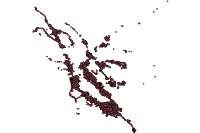

In [13]:
#Get item
transit_stops_exist_item = search_results[4]
transit_stops_exist_item

In [19]:
#Get layer and create spatial DF
transit_stops_exist_lyr = transit_stops_exist_item.layers[0]
transit_stops_exist_lyr

<FeatureLayer url:"https://arcgis.ad.mtc.ca.gov/server/rest/services/Hosted/Existing_Transit_Stops_2020/FeatureServer/0">

In [39]:
#Query entire layer and output spatial reference as NAD83 UTM Z 10N
tranit_stops_exist_nad83_lyr = transit_stops_exist_lyr.query(out_sr='26910')

In [40]:
tranit_stops_exist_nad83_lyr.spatial_reference

{'wkid': 26910, 'latestWkid': 26910}

In [55]:
transit_stops_exist_lyr.properties.capabilities

'Query'

In [41]:
#Convert layer to dataframe
transit_stops_exist_nad83_sdf = tranit_stops_exist_nad83_lyr.sdf
transit_stops_exist_nad83_sdf.head(10)

,objectid,stop_id,stop_code,stop_name,stop_desc,loc_type,hdwy_30min,hdwy_15min,major_stop,hdwy_class,agency_id,agency_nm,route_type,route_ty_t,SHAPE
0,1,12TH,12TH,12th St. Oakland City Center,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 564136.4098433314, ""y"": 4184292.66372085..."
1,2,16TH,16TH,16th St. Mission,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 551113.1694361205, ""y"": 4179906.44184228..."
2,3,19TH,19TH,19th St. Oakland,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 564383.3260366825, ""y"": 4184802.77724181..."
3,4,24TH,24TH,24th St. Mission,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 551258.3767569633, ""y"": 4178510.44246167..."
4,5,ANTC,ANTC,Antioch,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 607085.7075095321, ""y"": 4206004.63742061..."
5,6,ASHB,ASHB,Ashby,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 564216.2685953442, ""y"": 4189733.54973746..."
6,7,BALB,BALB,Balboa Park,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 548691.321425793, ""y"": 4175067.564707218..."
7,8,BAYF,BAYF,Bay Fair,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 577006.5595316953, ""y"": 4172546.94017915..."
8,9,CAST,CAST,Castro Valley,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 581501.5484727961, ""y"": 4171905.44242524..."
9,10,CIVC,CIVC,Civic Center/UN Plaza,,0,1,1,1,15 mins or less,BA,Bay Area Rapid Transit,2.0,Rail,"{""x"": 551593.5680305319, ""y"": 4181537.12486972..."


In [42]:
transit_stops_exist_nad83_sdf.spatial.sr

{'wkid': 26910, 'latestWkid': 26910}

In [43]:
transit_stops_exist_sdf['route_ty_t'].unique()

array(['Rail', 'Bus', 'Tram, Streetcar, Light Rail', 'Cable Tram'],
      dtype=object)

In [44]:
transit_stops_exist_sdf[transit_stops_exist_sdf['route_ty_t'] == 'Cable Tram']

,SHAPE,agency_id,agency_nm,hdwy_15min,hdwy_30min,hdwy_class,loc_type,major_stop,objectid,route_ty_t,route_type,stop_code,stop_desc,stop_id,stop_name
902,"{""x"": -122.39980999999995, ""y"": 37.79330000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,903,Cable Tram,5.0,13849,,13849,California St & Battery St
904,"{""x"": -122.40009999999995, ""y"": 37.79313000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,905,Cable Tram,5.0,17444,,17444,California St & Battery St
907,"{""x"": -122.39679999999998, ""y"": 37.79353000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,908,Cable Tram,5.0,17294,,17294,California St & Davis St
908,"{""x"": -122.39745999999997, ""y"": 37.79359000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,909,Cable Tram,5.0,13855,,13855,California St & Davis St
909,"{""x"": -122.39774999999997, ""y"": 37.79342000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,910,Cable Tram,5.0,13857,,13857,California St & Davis St
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,"{""x"": -122.41628999999995, ""y"": 37.79383000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,3669,Cable Tram,5.0,16922,,16922,Washington St & Leavenworth St
3669,"{""x"": -122.41135999999995, ""y"": 37.79453000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,1,3670,Cable Tram,5.0,16924,,16924,Washington St & Mason St
3670,"{""x"": -122.41152999999997, ""y"": 37.79444000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,0,3671,Cable Tram,5.0,16925,,16925,Washington St & Mason St
3672,"{""x"": -122.41003999999998, ""y"": 37.79463000000...",SF,San Francisco Municipal Transportation Agency,1,1,15 mins or less,0,1,3673,Cable Tram,5.0,16927,,16927,Washington St & Powell St


In [45]:
#Filter stops to include stops w/ types as well as stops with routes headways of 15 mins or less
transit_stops_exist_sdf = transit_stops_exist_sdf[(transit_stops_exist_sdf['hdwy_15min'] == 1) & 
                                                  (transit_stops_exist_sdf['route_ty_t'].isin(['Rail', 
                                                                                              'Bus', 
                                                                                              'Tram, Streetcar, Light Rail',
                                                                                              'Cable Tram',
                                                                                              'Ferry']))]

# Pull planned and potential stops from portal

In [57]:
#Search for planned transit stops
search_results = gis.content.search('title: Planned and Potential',
                  'Feature Layer')
search_results

[<Item title:"Planned and Proposed Transit Stops (2020)" type:Feature Layer Collection owner:msmith>,
 <Item title:"Transit Stops - Planned and Potential (2020)" type:Feature Layer Collection owner:msmith>]

<Item title:"Planned and Proposed Transit Stops (2020)" type:Feature Layer Collection owner:msmith>
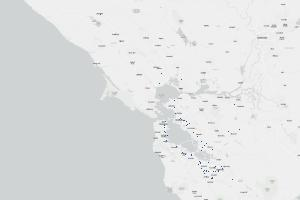

In [58]:
#Get item
transit_stops_plan_item = search_results[0]
transit_stops_plan_item

In [59]:
#Get layer and create spatial DF
transit_stops_plan_lyr = transit_stops_plan_item.layers[0]
transit_stops_plan_lyr

<FeatureLayer url:"https://arcgis.ad.mtc.ca.gov/server/rest/services/Hosted/Planned_and_Proposed_Transit_Stops_2020/FeatureServer/0">

In [63]:
transit_stops_exist_lyr.properties.advancedQueryCapabilities

{
  "supportsReturningQueryExtent": true,
  "supportsStatistics": true,
  "supportsDistinct": true,
  "supportsPagination": true,
  "supportsOrderBy": true,
  "supportsQueryWithDistance": true,
  "supportsLod": false,
  "supportsPaginationOnAggregatedQueries": true,
  "supportsQueryWithResultType": true,
  "supportsCountDistinct": true,
  "supportsReturningGeometryCentroid": false,
  "supportsHavingClause": true,
  "supportsQueryWithLodSR": false,
  "supportsTopFeaturesQuery": false,
  "supportsOrderByOnlyOnLayerFields": false,
  "supportsPercentileStatistics": true,
  "supportsQueryAttachments": true,
  "supportsQueryAttachmentsWithReturnUrl": true,
  "supportsQueryWithDatumTransformation": true
}

In [62]:
transit_stops_plan_lyr.properties.advancedQueryCapabilities

{
  "supportsReturningQueryExtent": true,
  "supportsStatistics": true,
  "supportsDistinct": true,
  "supportsPagination": true,
  "supportsOrderBy": true,
  "supportsQueryWithDistance": true,
  "supportsLod": false,
  "supportsPaginationOnAggregatedQueries": true,
  "supportsQueryWithResultType": true,
  "supportsCountDistinct": true,
  "supportsReturningGeometryCentroid": false,
  "supportsHavingClause": true,
  "supportsQueryWithLodSR": false,
  "supportsTopFeaturesQuery": false,
  "supportsOrderByOnlyOnLayerFields": false,
  "supportsPercentileStatistics": true,
  "supportsQueryAttachments": true,
  "supportsQueryAttachmentsWithReturnUrl": true,
  "supportsQueryWithDatumTransformation": true
}

In [61]:
#Query entire layer and output spatial reference as NAD83 UTM Z 10N
transit_stops_plan_lyr.query(out_sr='26910')

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'